In [1]:
# library

import pandas as pd
import datetime
import numpy as np
import joblib
import datetime as dt
from datetime import date 
from datetime import datetime
import awswrangler as wr
from mpl_toolkits.mplot3d import Axes3D # 3d plot

import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from re import search
import re

import pickle 
import warnings 

plt.rcParams['figure.figsize'] = (20, 10)
sns.set_style('whitegrid')

In [2]:
#Set Confuguration

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

sns.set(rc={'figure.figsize':(18,6)})

***Case***

Every company must a have a product that will be sold to customers
Using data set from Kaggle i'll build a machine learning model to clustering each customer and get the profile of customers, that will help for any department like CRM, Marketing etc to measure the performance and ensure target goes well.

In [3]:
#read the dataset
df_raw = pd.read_excel('online_retail.xlsx')

In [4]:
df_raw.tail()

,InvoiceNo,StockCode,lower,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,NaN,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.8500,12680.0000,France
541905,581587,22899,NaN,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.1000,12680.0000,France
541906,581587,23254,NaN,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.1500,12680.0000,France
541907,581587,23255,NaN,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.1500,12680.0000,France
541908,581587,22138,NaN,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.9500,12680.0000,France


***Data Wrangling***

In [5]:
df_raw.groupby('Country')['CustomerID'].nunique().head()

Country
Australia     9
Austria      11
Bahrain       2
Belgium      25
Brazil        1
Name: CustomerID, dtype: int64

In [6]:
df_raw['Amount'] = df_raw['Quantity'] * df_raw['UnitPrice']
df_raw.head()

,InvoiceNo,StockCode,lower,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,white hanging heart t-light holder,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom,15.3000
1,536365,71053,white metal lantern,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400
2,536365,84406B,cream cupid hearts coat hanger,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom,22.0000
3,536365,84029G,knitted union flag hot water bottle,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400
4,536365,84029E,red woolly hottie white heart.,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400


In [7]:
df_raw.isnull().sum()

InvoiceNo           0
StockCode           0
lower          540093
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
Amount              0
dtype: int64

In [8]:
# fill the null value in ID Customer to keep the information
df_raw['CustomerID'].fillna(df_raw['Country'].map(str)+ '-' + df_raw['Description'].map(str), inplace = True)

In [9]:
# Data Cleansing
df_raw1 = df_raw[['CustomerID','InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','Country','Amount']]
df_clean = df_raw1.dropna()

**Start for create clustering using K-means**

Pertama kita masukan data df_clean ke dalam df_kmeans dengan memperhatikan nilai variabel numeric yang akan diolah

First, we will assgin df_clean to variable df_kmeans that we will use for data modeling

In [10]:
df_kmeans = df_clean[['CustomerID','InvoiceDate','Quantity','Amount']]
df_kmeans['InvoiceDate']= pd.to_datetime(df_kmeans['InvoiceDate']).dt.date

df_kmeans['InvoiceDate'] = df_kmeans['InvoiceDate'].astype('datetime64')

/Users/user/opt/anaconda3/envs/daniel/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/user/opt/anaconda3/envs/daniel/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Data PreProcessing

In [11]:
#create df_agg for doing aggregation using groupby 
df_agg = df_kmeans.groupby('CustomerID').agg(
    Max_Transactions = pd.NamedAgg(column = 'Amount',aggfunc=max),
    Min_Transactions = pd.NamedAgg(column = 'Amount',aggfunc=min),
    Average_Transactions = pd.NamedAgg(column = 'Amount', aggfunc="mean"),
    Freq_Transactions = pd.NamedAgg(column = 'CustomerID', aggfunc=len),
    Max_Date = pd.NamedAgg(column = 'InvoiceDate',aggfunc=max),
    Min_Date = pd.NamedAgg(column = 'InvoiceDate',aggfunc=min),
    Amount = pd.NamedAgg(column = 'Amount',aggfunc=sum)
)

#create new column that name is age for given age of each of customer from first transactions and last transactions
df_agg['Recency'] = df_agg['Max_Date'] - df_agg['Min_Date']
df_agg['Recency'] = df_agg['Recency'].dt.days.astype('int16')


#using import datetime to convert the date of today
import datetime
def today_date():
    '''
    utils:
    get the datetime of today
    '''
    date=datetime.datetime.now().date()
    date=pd.to_datetime(date)
    return date
df_agg['Date'] = today_date()

#get column Age from delta Date colomn and Min_Date column
df_agg['Age'] = df_agg['Date'] - df_agg['Min_Date']
df_agg['Age'] = df_agg['Age'].dt.days.astype('int16')
df_agg

,Max_Transactions,Min_Transactions,Average_Transactions,Freq_Transactions,Max_Date,Min_Date,Amount,Recency,Date,Age
CustomerID,,,,,,,,,,
12346.0,77183.6000,-77183.6000,0.0000,2,2011-01-18,2011-01-18,0.0000,0,2022-02-06,4037
12347.0,249.6000,5.0400,23.6813,182,2011-12-07,2010-12-07,4310.0000,365,2022-02-06,4079
12348.0,240.0000,13.2000,57.9755,31,2011-09-25,2010-12-16,1797.2400,283,2022-02-06,4070
12349.0,300.0000,6.6400,24.0760,73,2011-11-21,2011-11-21,1757.5500,0,2022-02-06,3730
12350.0,40.0000,8.5000,19.6706,17,2011-02-02,2011-02-02,334.4000,0,2022-02-06,4022
...,...,...,...,...,...,...,...,...,...,...
Unspecified-WASH BAG VINTAGE ROSE PAISLEY,2.5500,2.5500,2.5500,1,2011-07-08,2011-07-08,2.5500,0,2022-02-06,3866
Unspecified-WOODEN BOX OF DOMINOES,15.0000,6.2500,10.0000,3,2011-11-24,2011-07-08,30.0000,139,2022-02-06,3866
Unspecified-WOODEN HAPPY BIRTHDAY GARLAND,17.7000,2.9500,10.3250,2,2011-07-08,2011-05-19,20.6500,50,2022-02-06,3916


In [12]:
#Assign to df_ml where we have to select columns that we will use for modeling
df_ml = df_agg.iloc[:,[0,1,2,3,6,7,9]]

/Users/user/opt/anaconda3/envs/daniel/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Average_Transactions', ylabel='Density'>

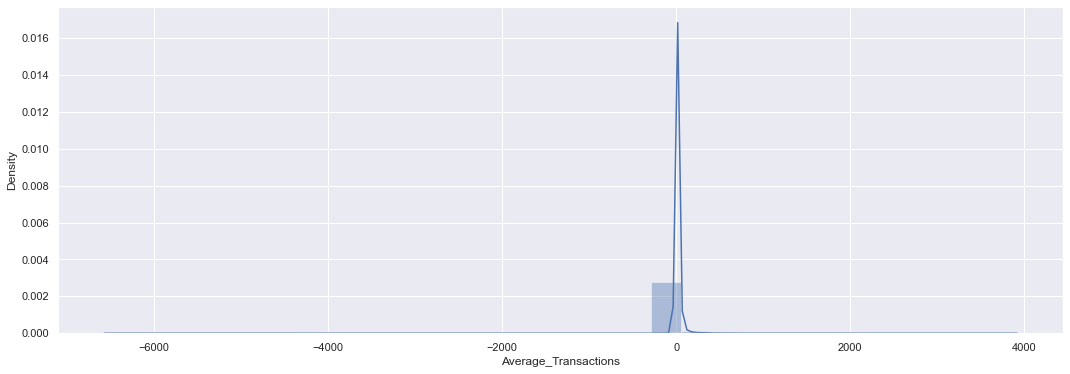

In [13]:
#Eksploratory Data Analysis

sns.distplot(df_ml['Average_Transactions'], bins = 30)

Text(0.5, 1.0, 'Scatter plot between Freq and Amount')

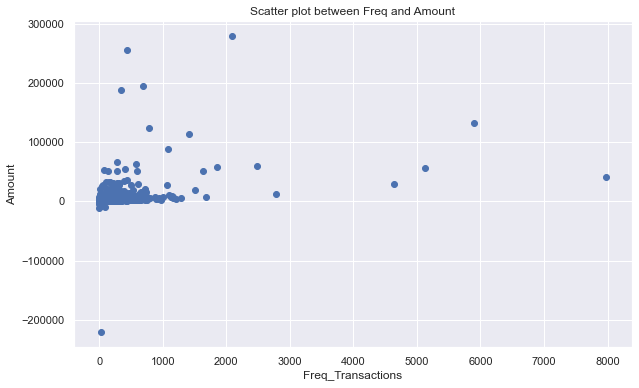

In [14]:
#Check the scatter plot to see corelation and anomali data

plt.figure(figsize=(10,6))
plt.scatter(df_ml['Freq_Transactions'],df_ml['Amount'], marker='o');
plt.xlabel('Freq_Transactions')
plt.ylabel('Amount')
plt.title('Scatter plot between Freq and Amount')

From the ghrapic and plot we saw for average transactions is belom from 0, and we will drop the data because it means like canceled order from customer

In [15]:
# exclude df_ml from Amount < 1
row_cut = df_ml['Amount'] <1
df_ml = df_ml[~row_cut]

Seperate the customer 'row_exclude' that have special value from amount and frequency of transactions, and we will labeling with 
Special Customer. and avoid data bias

Text(0.5, 1.0, 'Scatter plot between Freq and Amount')

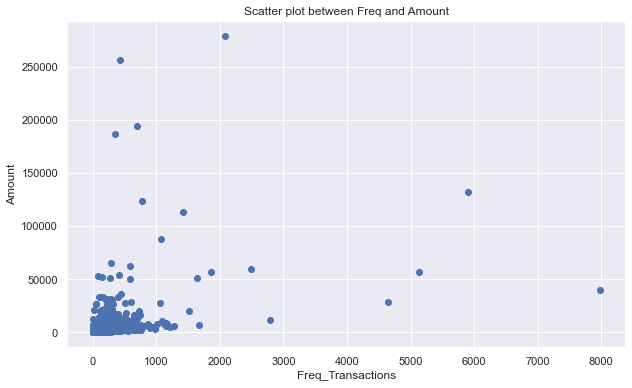

In [16]:
#Exclude the row who have <= 0 Amount
plt.figure(figsize=(10,6))
plt.scatter(df_ml['Freq_Transactions'],df_ml['Amount'], marker='o');
plt.xlabel('Freq_Transactions')
plt.ylabel('Amount')
plt.title('Scatter plot between Freq and Amount')

<AxesSubplot:>

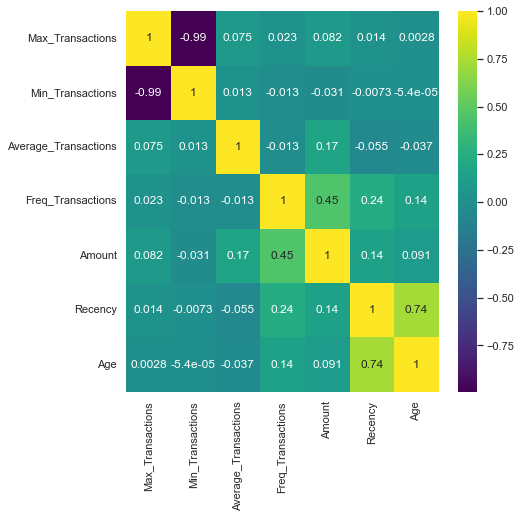

In [17]:
# see the correlation between each variable, example 'Max_Transactions have negatively' correlated with 'Min_Transactions'

fig_dims = (7, 7)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(df_ml.corr(), annot=True, cmap='viridis')

In [18]:
# Standardizing the variables

scaler = StandardScaler().fit_transform(df_ml.values)
scaled_data = pd.DataFrame(scaler, index = df_ml.index, columns=df_ml.columns)
scaled_data.head()

,Max_Transactions,Min_Transactions,Average_Transactions,Freq_Transactions,Amount,Recency,Age
CustomerID,,,,,,,
12347.0,0.0737,0.0190,0.0306,0.6928,0.4962,1.3565,0.9710
12348.0,0.0686,0.0233,0.4831,-0.1851,0.0994,0.7950,0.8970
12349.0,0.1004,0.0198,0.0358,0.0591,0.0931,-1.1429,-1.8980
12350.0,-0.0374,0.0208,-0.0223,-0.2665,-0.1316,-1.1429,0.5024
12352.0,0.1410,-0.1843,-0.0672,0.1870,0.0596,0.6375,0.3874


Text(0, 0.5, 'within Clusters Sum of Squares(WCSS)')

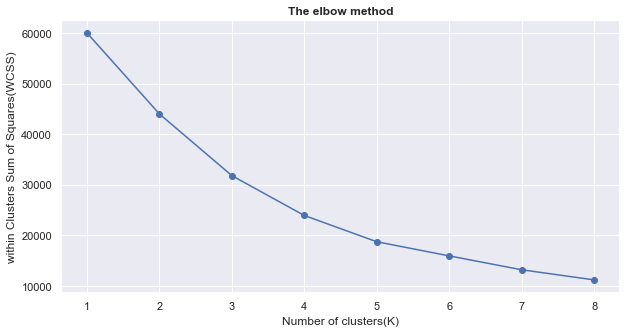

In [19]:
#Building Cluster Model, but before it we will find most appropriate 'K' Use The Elbow Method

wcss=[]
for i in range(1, 9):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', 
                    max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(scaled_data)
    wcss_iter=kmeans.inertia_
    wcss.append(wcss_iter)
# Plotting the results onto a line graph to help us observe 'The Elbow'
plt.figure(figsize=(10,5))
no_clusters=range(1,9)
plt.plot(no_clusters, wcss,marker = "o")
plt.title('The elbow method', fontweight="bold")
plt.xlabel('Number of clusters(K)')
plt.ylabel('within Clusters Sum of Squares(WCSS)')

In [20]:
#Implement Kmeans Model

kmeans = KMeans(5)
#fit the data
kmeans.fit(scaled_data)

#Create a new data frame with the predicted clusters

df_cluster = df_ml
# cluster = scaled_data.copy()
df_cluster['cluster_pred'] = kmeans.fit_predict(scaled_data)


In [21]:
#Labeling cluster for each customers
df_cluster.head()

,Max_Transactions,Min_Transactions,Average_Transactions,Freq_Transactions,Amount,Recency,Age,cluster_pred
CustomerID,,,,,,,,
12347.0,249.6000,5.0400,23.6813,182,4310.0000,365,4079,0
12348.0,240.0000,13.2000,57.9755,31,1797.2400,283,4070,0
12349.0,300.0000,6.6400,24.0760,73,1757.5500,0,3730,2
12350.0,40.0000,8.5000,19.6706,17,334.4000,0,4022,2
12352.0,376.5000,-376.5000,16.2675,95,1545.4100,260,4008,0


In [22]:
#cluster profilling
df_cluster.groupby('cluster_pred').mean()

,Max_Transactions,Min_Transactions,Average_Transactions,Freq_Transactions,Amount,Recency,Age
cluster_pred,,,,,,,
0,100.7380,-15.7405,16.7886,92.3887,1574.1071,300.5935,4055.5993
1,168469.6000,-168469.6000,0.7250,4.0000,2.9000,205.0000,3917.0000
2,70.5839,-4.1034,22.2536,27.4426,413.0833,40.8549,3871.6966
3,3301.2500,613.4500,2248.3507,5.1667,8278.0833,69.6667,3871.1667
4,2383.1785,-1102.7269,150.8694,2680.0000,124530.4154,342.5385,4058.5385


Text(0, 0.5, 'Age')

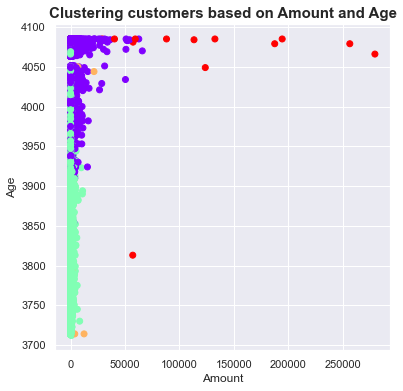

In [23]:
plt.figure(figsize=(6,6))
plt.scatter(df_cluster['Amount'],df_cluster['Age'],c=df_cluster['cluster_pred'],cmap='rainbow')
plt.title("Clustering customers based on Amount and Age", fontsize=15,fontweight="bold")
plt.xlabel("Amount")
plt.ylabel("Age")

/Users/user/opt/anaconda3/envs/daniel/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  


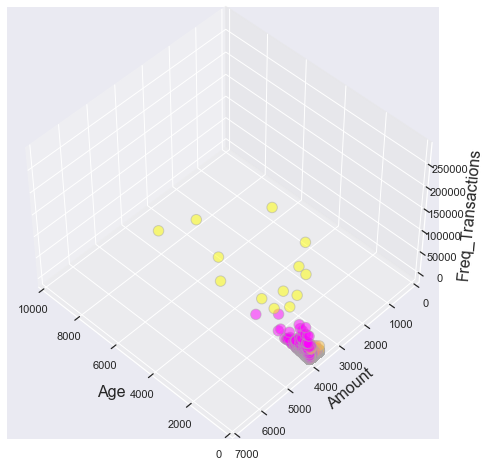

In [24]:
# Using 3D for see the cluster

fig = plt.figure(1)
plt.clf()
ax = Axes3D(fig, 
            rect = [0, 0, .95, 1], 
            elev = 48, 
            azim = 134)

plt.cla()
ax.scatter(df_cluster['Freq_Transactions'], df_cluster['Age'], df_cluster['Amount'], 
           c = df_cluster['cluster_pred'], 
           s = 110, 
           cmap = 'spring', 
           alpha = 0.5, 
           edgecolor = 'darkgrey')
ax.set_xlabel('Age', 
              fontsize = 16)
ax.set_ylabel('Amount', 
              fontsize = 16)
ax.set_zlabel('Freq_Transactions', 
              fontsize = 16)

plt.xlim(0,10000)
plt.ylim(0,7000)

plt.savefig('3d_plot.png')
plt.show()